<a href="https://colab.research.google.com/github/SOWMYASRI7/DL-Assignment-1/blob/main/EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Load Dataset

In [2]:
# Load EMNIST dataset (digits only)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.EMNIST(root='./data', split='digits', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.EMNIST(root='./data', split='digits', train=False, transform=transform, download=True)

# Split training data into train and validation (90-10 split)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])



100%|██████████| 562M/562M [00:06<00:00, 87.6MB/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


# Define Hyperparameters

In [3]:
batch_size = 64
num_epochs = 10
learning_rate = 1e-3
hidden_layers = [32, 64, 128]  # Configurable hidden layers
activation_function = nn.ReLU  # Change to nn.Sigmoid if needed
weight_init = "xavier"  # Options: "random", "xavier"
optimizers_to_test = ["sgd", "momentum", "nesterov", "rmsprop", "adam"]

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Plot Sample Images

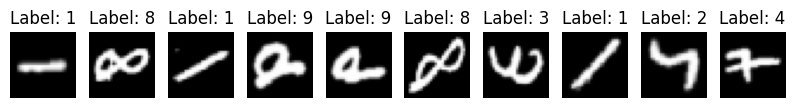

In [4]:
def plot_sample_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

plot_sample_images(train_dataset)


# Define Neural Network

In [5]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation_fn):
        super(FeedForwardNN, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(activation_fn())
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Initialize Weights

In [6]:
def initialize_weights(model, init_type):
    for layer in model.network:
        if isinstance(layer, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            else:
                nn.init.uniform_(layer.weight, -0.1, 0.1)


# Define Optimizer Selection

In [7]:
def get_optimizer(opt_name, model, lr):
    if opt_name == "sgd":
        return optim.SGD(model.parameters(), lr=lr)
    elif opt_name == "momentum":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif opt_name == "nesterov":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    elif opt_name == "rmsprop":
        return optim.RMSprop(model.parameters(), lr=lr)
    elif opt_name == "adam":
        return optim.Adam(model.parameters(), lr=lr)

# Define Training Function

In [8]:
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
    return model


# Define Evaluation & Confusion Matrix

In [9]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# Train & Evaluate Models for Different Optimizers


Training with sgd optimizer...

Epoch 1/10, Loss: 1.1465
Epoch 2/10, Loss: 0.3693
Epoch 3/10, Loss: 0.2935
Epoch 4/10, Loss: 0.2623
Epoch 5/10, Loss: 0.2421
Epoch 6/10, Loss: 0.2268
Epoch 7/10, Loss: 0.2145
Epoch 8/10, Loss: 0.2040
Epoch 9/10, Loss: 0.1952
Epoch 10/10, Loss: 0.1876
Validation Accuracy with sgd: 94.87%
Test Accuracy with sgd: 94.65%


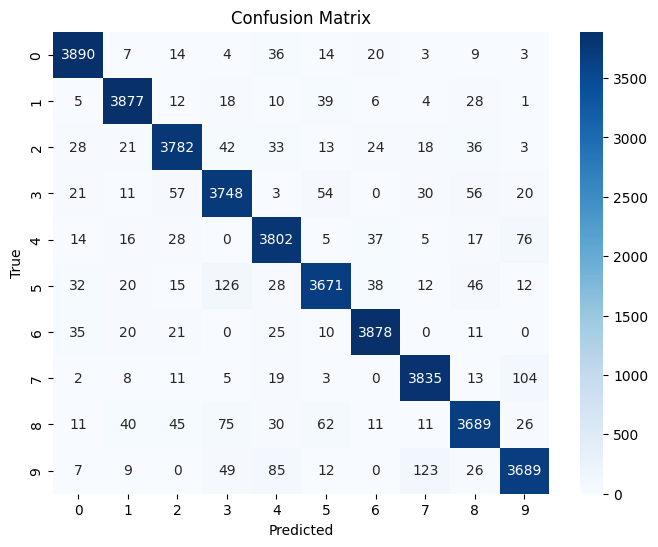


Training with momentum optimizer...

Epoch 1/10, Loss: 0.3527
Epoch 2/10, Loss: 0.1685
Epoch 3/10, Loss: 0.1342
Epoch 4/10, Loss: 0.1153
Epoch 5/10, Loss: 0.1035
Epoch 6/10, Loss: 0.0945
Epoch 7/10, Loss: 0.0874
Epoch 8/10, Loss: 0.0812
Epoch 9/10, Loss: 0.0764
Epoch 10/10, Loss: 0.0724
Validation Accuracy with momentum: 97.95%
Test Accuracy with momentum: 97.82%


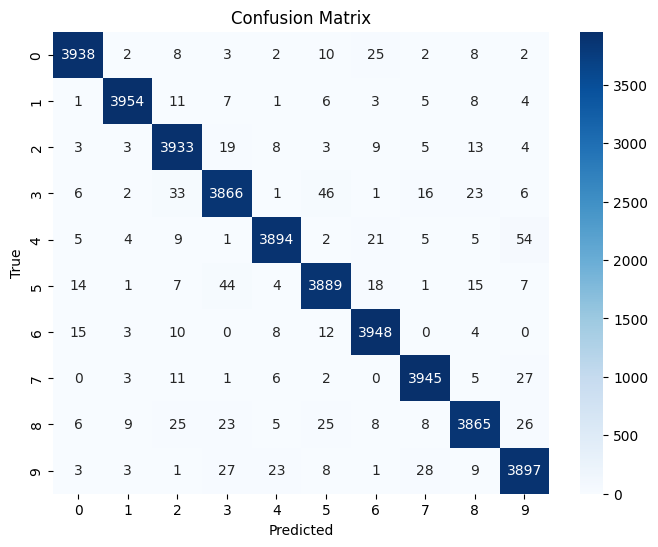


Training with nesterov optimizer...

Epoch 1/10, Loss: 0.3537
Epoch 2/10, Loss: 0.1733
Epoch 3/10, Loss: 0.1421
Epoch 4/10, Loss: 0.1235
Epoch 5/10, Loss: 0.1095
Epoch 6/10, Loss: 0.0994
Epoch 7/10, Loss: 0.0916
Epoch 8/10, Loss: 0.0845
Epoch 9/10, Loss: 0.0791
Epoch 10/10, Loss: 0.0746
Validation Accuracy with nesterov: 97.70%
Test Accuracy with nesterov: 97.62%


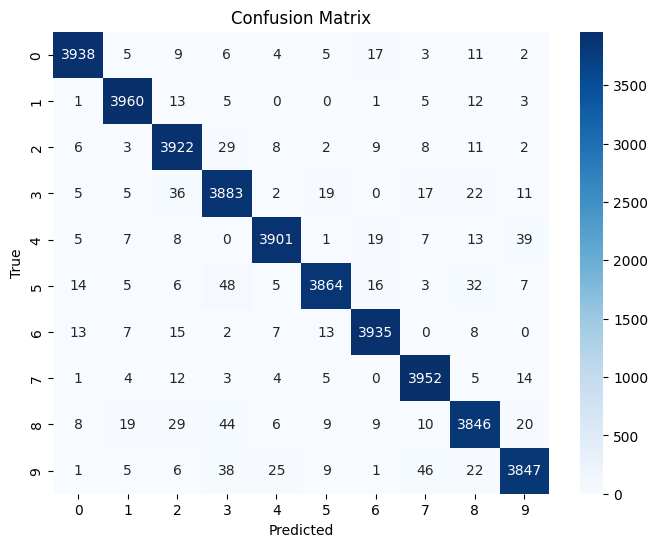


Training with rmsprop optimizer...

Epoch 1/10, Loss: 0.1938
Epoch 2/10, Loss: 0.1097
Epoch 3/10, Loss: 0.0911
Epoch 4/10, Loss: 0.0813
Epoch 5/10, Loss: 0.0742
Epoch 6/10, Loss: 0.0699
Epoch 7/10, Loss: 0.0667
Epoch 8/10, Loss: 0.0632
Epoch 9/10, Loss: 0.0614
Epoch 10/10, Loss: 0.0605
Validation Accuracy with rmsprop: 97.89%
Test Accuracy with rmsprop: 97.77%


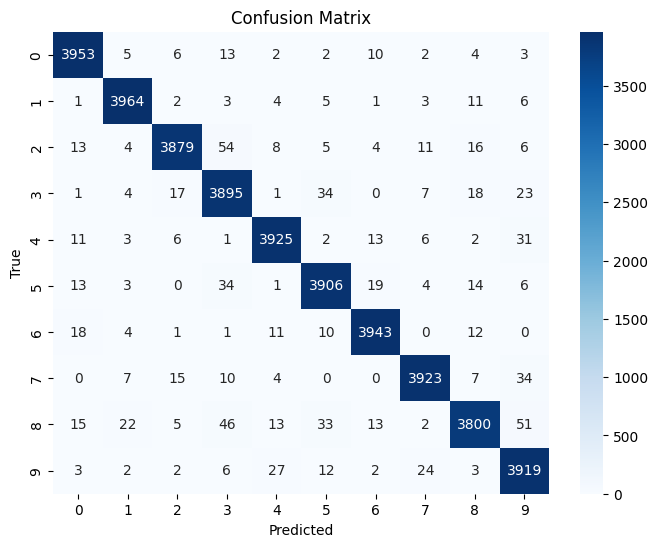


Training with adam optimizer...

Epoch 1/10, Loss: 0.1891
Epoch 2/10, Loss: 0.1016
Epoch 3/10, Loss: 0.0846
Epoch 4/10, Loss: 0.0742
Epoch 5/10, Loss: 0.0676
Epoch 6/10, Loss: 0.0633
Epoch 7/10, Loss: 0.0598
Epoch 8/10, Loss: 0.0561
Epoch 9/10, Loss: 0.0540
Epoch 10/10, Loss: 0.0511
Validation Accuracy with adam: 98.33%
Test Accuracy with adam: 98.20%


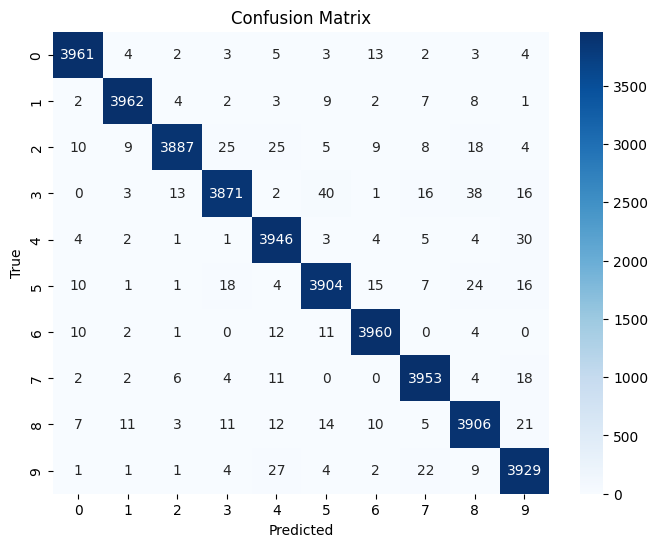

In [10]:
results = {}

for opt_name in optimizers_to_test:
    print(f"\nTraining with {opt_name} optimizer...\n")

    # Reinitialize model and weights
    model = FeedForwardNN(28*28, hidden_layers, 10, activation_function).to(device)  # 10 output classes
    initialize_weights(model, weight_init)

    # Get optimizer
    optimizer = get_optimizer(opt_name, model, learning_rate)

    # Train model
    trained_model = train_model(model, train_loader, optimizer, num_epochs)

    # Evaluate model
    val_acc = evaluate_model(trained_model, val_loader)
    test_acc = evaluate_model(trained_model, test_loader)

    # Store results
    results[opt_name] = {"Validation Accuracy": val_acc, "Test Accuracy": test_acc}
    print(f"Validation Accuracy with {opt_name}: {val_acc*100:.2f}%")
    print(f"Test Accuracy with {opt_name}: {test_acc*100:.2f}%")

    # Plot confusion matrix
    plot_confusion_matrix(trained_model, test_loader)



# Final Results

In [11]:
print("\nFinal Results Comparison:")
for opt, metrics in results.items():
    print(f"{opt}: Val Acc = {metrics['Validation Accuracy']*100:.2f}%, Test Acc = {metrics['Test Accuracy']*100:.2f}%")



Final Results Comparison:
sgd: Val Acc = 94.87%, Test Acc = 94.65%
momentum: Val Acc = 97.95%, Test Acc = 97.82%
nesterov: Val Acc = 97.70%, Test Acc = 97.62%
rmsprop: Val Acc = 97.89%, Test Acc = 97.77%
adam: Val Acc = 98.33%, Test Acc = 98.20%


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Split train into training and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

def get_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation_fn):
        super(FeedForwardNN, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(activation_fn())
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def initialize_weights(model, init_type):
    for layer in model.network:
        if isinstance(layer, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            else:
                nn.init.uniform_(layer.weight, -0.1, 0.1)

def get_optimizer(opt_name, model, lr, weight_decay):
    if opt_name == "sgd":
        return optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt_name == "momentum":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif opt_name == "rmsprop":
        return optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt_name == "adam":
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
    return model

def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# --- Configuration 1 ---
train_loader, val_loader, test_loader = get_dataloaders(batch_size=32)
model = FeedForwardNN(28*28, [32, 64, 128], 10, nn.ReLU).to(device)
initialize_weights(model, "xavier")
optimizer = get_optimizer("adam", model, lr=1e-3, weight_decay=0.0005)
trained_model = train_model(model, train_loader, optimizer, num_epochs=10)
val_acc = evaluate_model(trained_model, val_loader)
test_acc = evaluate_model(trained_model, test_loader)
print(f"Config 1 - Validation Accuracy: {val_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%")

# --- Configuration 2 ---
train_loader, val_loader, test_loader = get_dataloaders(batch_size=64)
model = FeedForwardNN(28*28, [32, 64, 128, 256], 10, nn.ReLU).to(device)
initialize_weights(model, "random")
optimizer = get_optimizer("momentum", model, lr=1e-3, weight_decay=0)
trained_model = train_model(model, train_loader, optimizer, num_epochs=10)
val_acc = evaluate_model(trained_model, val_loader)
test_acc = evaluate_model(trained_model, test_loader)
print(f"Config 2 - Validation Accuracy: {val_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%")

# --- Configuration 3 ---
train_loader, val_loader, test_loader = get_dataloaders(batch_size=16)
model = FeedForwardNN(28*28, [64, 128, 256], 10, nn.Sigmoid).to(device)
initialize_weights(model, "xavier")
optimizer = get_optimizer("rmsprop", model, lr=1e-4, weight_decay=0.5)
trained_model = train_model(model, train_loader, optimizer, num_epochs=10)
val_acc = evaluate_model(trained_model, val_loader)
test_acc = evaluate_model(trained_model, test_loader)
print(f"Config 3 - Validation Accuracy: {val_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 56.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.81MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.78MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10, Loss: 0.3676
Epoch 2/10, Loss: 0.1932
Epoch 3/10, Loss: 0.1578
Epoch 4/10, Loss: 0.1396
Epoch 5/10, Loss: 0.1258
Epoch 6/10, Loss: 0.1157
Epoch 7/10, Loss: 0.1098
Epoch 8/10, Loss: 0.1037
Epoch 9/10, Loss: 0.0989
Epoch 10/10, Loss: 0.0958
Config 1 - Validation Accuracy: 96.25%, Test Accuracy: 96.17%
Epoch 1/10, Loss: 1.9616
Epoch 2/10, Loss: 0.5926
Epoch 3/10, Loss: 0.4085
Epoch 4/10, Loss: 0.3519
Epoch 5/10, Loss: 0.3108
Epoch 6/10, Loss: 0.2823
Epoch 7/10, Loss: 0.2601
Epoch 8/10, Loss: 0.2395
Epoch 9/10, Loss: 0.2237
Epoch 10/10, Loss: 0.2089
Config 2 - Validation Accuracy: 93.25%, Test Accuracy: 93.78%
Epoch 1/10, Loss: 2.3043
Epoch 2/10, Loss: 2.3033
Epoch 3/10, Loss: 2.3034
Epoch 4/10, Loss: 2.3034
Epoch 5/10, Loss: 2.3034
Epoch 6/10, Loss: 2.3033
Epoch 7/10, Loss: 2.3036
Epoch 8/10, Loss: 2.3032
Epoch 9/10, Loss: 2.3036
Epoch 10/10, Loss: 2.3033
Config 3 - Validation Accuracy: 11.05%, Test Acc